## Inference and Analysis Using the Retrained DeLTA 2.0 Model

**Important:**  
DeLTA 2.0 expects input images to follow the naming convention  
`pos1cha1fra000001.png`.

Input images must be single-channel and resized to the expected dimensions  
(height × width): **782 × 499** pixels.

It is highly recommended to run this notebook utilizing Colabs GPU capabilities, inference on cpu is very time consuming

In [ ]:
!pip install delta-microscopy[jax-gpu]

In [1]:
!git clone https://github.com/joelsundin/forskningsmetodik_2025_Delta2.0.git

Cloning into 'forskningsmetodik_2025_Delta2.0'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 1.97 MiB | 19.94 MiB/s, done.


In [2]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1CILkZPZuq8MO38Vp9qfIwFi99uiCdHyy
!mv 1CILkZPZuq8MO38Vp9qfIwFi99uiCdHyy delta2_retrained_model.keras

Downloading...
From (original): https://drive.google.com/uc?id=1CILkZPZuq8MO38Vp9qfIwFi99uiCdHyy
From (redirected): https://drive.google.com/uc?id=1CILkZPZuq8MO38Vp9qfIwFi99uiCdHyy&confirm=t&uuid=4433caec-eb84-42e9-81ca-16c09a830f3b
To: /content/final_delta_model.keras
100% 373M/373M [00:03<00:00, 98.6MB/s]
mv: cannot stat '1CILkZPZuq8MO38Vp9qfIwFi99uiCdHyy': No such file or directory


In [3]:
import delta
from delta.config import Config
import logging
from IPython.display import HTML
from base64 import b64encode
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import shutil
import os
import re
import glob
import pandas as pd
import random
from pathlib import Path

Helper functions used later

In [16]:
# Helper Functions
def add_frame_bins(df, step=10):
    df = df.copy()
    df["frame_bin"] = (df["frame"] // step) * step
    return df


def aggregate_gr(df, step=10):
    df = add_frame_bins(df, step)

    # Growth rate (area) bin (steps)
    agg_area = df.groupby("frame_bin")["growthrate_area"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)
    agg_area["smooth"] = agg_area["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    # Growth rate (length) bin (steps)
    agg_length = df.groupby("frame_bin")["growthrate_length"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_length["sem"] = agg_length["std"] / agg_length["count"].pow(0.5)
    agg_length["smooth"] = agg_length["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    return agg_area, agg_length

def average_area(df):
    # No binning here
    agg_area = df.groupby("frame")["area"].agg(
        mean="mean",
        median="median",
        std="std",
        count="count"
    )
    agg_area["sem"] = agg_area["std"] / agg_area["count"].pow(0.5)
    agg_area["smooth"] = agg_area["mean"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    return agg_area

def create_df(nc_file: Path, step=10):
    pos = delta.pipeline.Position.load_netcdf(nc_file)
    roi = pos.rois[0]
    lin = roi.lineage

    rows = []
    for cell_id, cell in lin.cells.items():
        for frame in cell.frames:
            f = cell.features(frame)
            rows.append({
                "cell_id": cell_id,
                "frame": frame,
                "length": f.length,
                "area": f.area,
                "growthrate_length": f.growthrate_length,
                "growthrate_area": f.growthrate_area,
                "motherid": cell.motherid,
            })

    df_raw = pd.DataFrame(rows)

    # Binned growth rates
    agg_area, agg_length = aggregate_gr(df_raw, step)

    # Unbinned area
    avr_area = average_area(df_raw)

    return df_raw, agg_area, agg_length, avr_area


def visualize_comparison(agg1, agg2, label1, label2, y_label, title=""):
    plt.figure(figsize=(10,4))

    agg1["median_smooth"] = agg1["median"].rolling(window=3, center=True, min_periods=1).mean()
    plt.plot(agg1.index, agg1["median"], alpha=0.3, label=f"{label1} median")
    plt.plot(agg1.index, agg1["median_smooth"], linewidth=2, label=f"{label1} smoothed median")
    plt.fill_between(
        agg1.index,
        agg1["median"] - agg1["sem"],
        agg1["median"] + agg1["sem"],
        alpha=0.2
    )

    agg2["median_smooth"] = agg2["median"].rolling(window=3, center=True, min_periods=1).mean()
    plt.plot(agg2.index, agg2["median"], alpha=0.3, label=f"{label2} median")
    plt.plot(agg2.index, agg2["median_smooth"], linewidth=2, label=f"{label2} smoothed median")
    plt.fill_between(
        agg2.index,
        agg2["median"] - agg2["sem"],
        agg2["median"] + agg2["sem"],
        alpha=0.2
    )

    plt.xlabel("Frame bin")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_single(agg, label, y_label, title=""):
    plt.figure(figsize=(10, 4))

    # Smoothed median
    agg["median_smooth"] = agg["median"].rolling(
        window=3, center=True, min_periods=1
    ).mean()

    # Median and smoothed median
    plt.plot(agg.index, agg["median"], alpha=0.3, label=f"{label} median")
    plt.plot(
        agg.index,
        agg["median_smooth"],
        linewidth=2,
        label=f"{label} smoothed median"
    )

    # SEM shading
    plt.fill_between(
        agg.index,
        agg["median"] - agg["sem"],
        agg["median"] + agg["sem"],
        alpha=0.2
    )

    plt.xlabel("Frame bin")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def auc_growth(agg):
    x = agg.index.values
    y = agg["smooth"].values
    return np.trapz(y, x)

In [10]:
# Here we handle filename format and size of the images for DeLTA 2.0
# Our files are placed within /content/aphase/aphase and are named in a numbered manner,
# ensuring correct sequence.
# Target filenames:   pos{POSITION}cha1fra{frame:06d}.tiff
# Target size:        782 x 499 (height x width)
# Ensure that your data is in the correct format

POSITION = 207
TARGET_HEIGHT, TARGET_WIDTH = 782, 499
IMAGE_DIR = Path("/content/aphase/aphase")

pattern = re.compile(r"img_(\d+)\.tiff$", re.IGNORECASE)
for img_path in sorted(IMAGE_DIR.iterdir()):
    if not img_path.is_file():
        continue
    m = pattern.match(img_path.name)
    if not m:
        continue
    frame_num = int(m.group(1))
    img = np.array(Image.open(img_path))
    resized = img[:TARGET_HEIGHT, :TARGET_WIDTH]
    new_name = f"pos{POSITION}cha1fra{frame_num + 1:06d}.tiff"
    new_path = img_path.with_name(new_name)
    Image.fromarray(resized).save(new_path)

print("Done: images resized and renamed.")

Done: images resized and renamed.


Here we are processing only 60 frames, do alter *frames=range(1,N)* to a preferred range of frames.
The results, including a video of the tracked cells are stored in */content/results*

In [14]:
config = Config.default("2D")
config.models['seg'].model_path = Path("/content/final_delta_model.keras")

movie_path = "/content/aphase/aphase/pos{p}cha{c}fra{t}.tiff"
reader = delta.utils.XPReader(movie_path)
pipeline = delta.pipeline.Pipeline(reader, config, resfolder="results")
pipeline.process(positions=[207, 0], frames=range(1, 61))

In [17]:
nc = Path("/content/results/Position000207.nc") # change this to your file
df_raw, agg_area, agg_length, avr_area = create_df(nc, step=10) # step is our bin size, currently 10

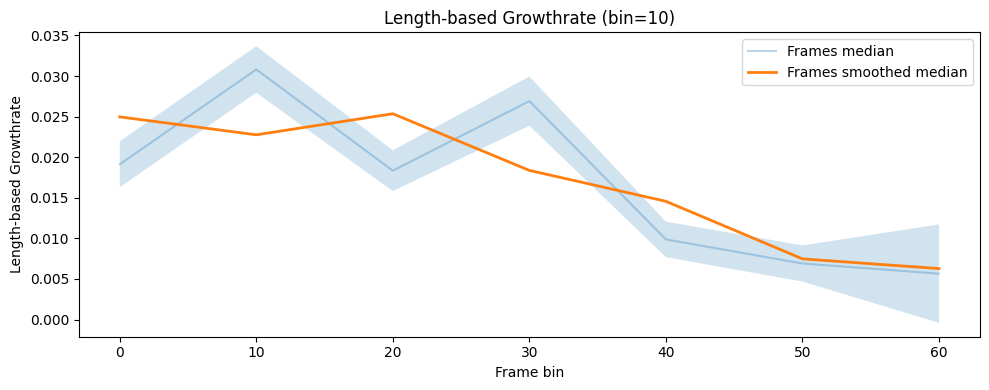

In [19]:
visualize_single(agg_length, "Frames", "Length-based Growthrate", title="Length-based Growthrate (bin=10)")

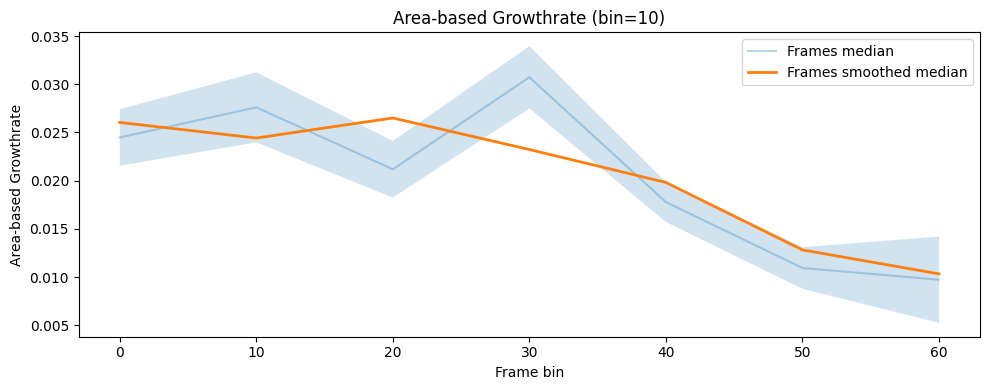

In [20]:
visualize_single(agg_area, "Frames", "Area-based Growthrate", title="Area-based Growthrate (bin=10)")

### Comparing Drug-Treated and Control Movies

To compare a drug-treated movie with its corresponding reference (control), follow these steps:
- Process the drug-treated movie (e.g., *RIF10*) and its paired control movie using the same analysis pipeline.
- Pair the resulting aggregated data for the drug and control conditions.
- Use the function  
  `visualize_comparison(agg1, agg2, label1, label2, y_label, title="")`  
  to visualize the aggregated growth features for the two conditions.

Drug response can be quantified by computing the percent change in the area under the smoothed growth-rate curve (AUC) relative to the control:
\[
100 \cdot \frac{AUC_{\text{drug}} - AUC_{\text{ctrl}}}{AUC_{\text{ctrl}}}
\]

Please refer to the example cell below for guidance on how this comparison is implemented.


In [ ]:
# Compute AUC-based drug response for a paired control and drug-treated movie
rows = []

# Paths to paired NetCDF files (control and drug-treated)
nc_ctrl = Path("path/to/control_movie.nc")
nc_drug = Path("path/to/drug_movie.nc")

# Identifier for the strain or position
strain = "e.g., 204"

# Aggregate area-based growth rates using 10-frame bins
_, agg_area_ctrl, _, _ = create_df(nc_ctrl, step=10)
_, agg_area_drug, _, _ = create_df(nc_drug, step=10)

# Compute area under the smoothed growth-rate curve (AUC)
auc_ctrl = auc_growth(agg_area_ctrl)
auc_drug = auc_growth(agg_area_drug)

# Store results
rows.append({
    "strain": strain[-3:],
    "auc_control": auc_ctrl,
    "auc_drug": auc_drug,
    "delta_auc": auc_drug - auc_ctrl,
    "percent_change": 100 * (auc_drug - auc_ctrl) / auc_ctrl
})

# Create summary DataFrame
sus_df = pd.DataFrame(rows).sort_values("percent_change")
sus_df
